# Q-Learning

This algorithm using greedy.
But like below situation alway do same action.

(example1)
|    |    |    |    |
|----|----|----|----|  
|0010|0010|0010|0100|
|0100|1000|1000|1000|
|0010|0010|0010|0100|
|0000|0000|0000|goal|

### Epsilon

So we have to using exploration & exploitation and we call it epsilon_greedy.  
Exploration is't greedy action but by doing that something agent've never tried we can find better than before result.    
By doing exploration, we can have two profit.  
1. if we have multi goals we can find more higher reward goal
2. we can arrive goal in an optimized way so we can get more higher reward

When using epsilon_greedy Q-Learning execute above example, we can see like below situation.

(example2)
|    |    |    |    |
|----|----|----|----|  
|0010|0010|0010|0100|
|0000|0000|0000|0100|
|0000|0000|0000|0100|
|0000|0000|0000|goal|

more optimal -> decaying_epsilon_greedy  
We have to think what ratio should you adjust it to exploration & exploitation?  
The decaying_epsilon_greedy method causes the epsilon value to gradually decrease.  
Therefore, try a lot of exploration in the beginning and gradually reduce the proportion of exploration.  

*별첨*
- exploitation : 오직 성과만을 따라 행동
- exploration : 성과에 상관없이 탐험 해보지 않은 것을 행함

### Discount facotr

With the introduction of epsilon, the optimal route has been found, but how do we determine which route is best?  
Below two example is same reward so we can't determine wich is best.  

(example1)
|    |    |    |    |
|----|----|----|----|  
|0010|0010|0010|0100|
|0100|1000|1000|1000|
|0010|0010|0010|0100|
|0000|0000|0000|goal|

(example2)
|    |    |    |    |
|----|----|----|----|  
|0010|0010|0010|0100|
|0000|0000|0000|0100|
|0000|0000|0000|0100|
|0000|0000|0000|goal|

So introduction discount factor(gamma).
Gamma is 0~1 floating number so the more multiply, the smaller it becomes.  
Therefore, if the Q-Table maintains the value by multiplying the reward of the next action by gamma, it is possible to determine which is more best.  
In other words, gamma is an indicator that allows you to know the rewards you will receive in the future.

### Q-Update

$Q(S_t,a_t) \gets (1-\alpha)Q(S_t,a_t) + \alpha(R_t + \gamma( maxQ(S_{t+1}, a_{t+1})) )$

- $\alpha$ : this value is 0~1 & this value mean how much do you accept new things

In [16]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import gymnasium as gym; print(f"gym.__version__: {gym.__version__}")
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning)

gym.__version__: 0.29.1


In [17]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [18]:
ACTION_STRING_LIST = [" LEFT", " DOWN", "RIGHT", "   UP"]
IS_SLIPPERY = False
MAP_NAME = "4x4"
DESC = None

## QTable Agent

In [25]:
class QTableAgent:
    def __init__(self, env, num_episodes, validation_num_episodes, alpha, gamma, epsilon):
        self.env = env
        self.num_episodes = num_episodes
        self.validation_num_episodes = validation_num_episodes
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.zeros(
            [env.observation_space.n, env.action_space.n]
        )

    # this function using only exploitation
    def greedy_action(self, observation):
        action_values = self.q_table[observation, :]
        max_value = np.max(action_values)
        action = np.random.choice(
            [action_ for action_, value_ in enumerate(action_values) if value_ == max_value]
        )
        return action

    # this function using exploitation & exploration
    def epsilon_greedy_action(self, observation):
        action_values = self.q_table[observation, :]
        if np.random.rand() < self.epsilon:
            action = random.choice(range(len(action_values)))
        else:
            max_value = np.max(action_values)
            action = np.random.choice(
                [action_ for action_, value_ in enumerate(action_values) if value_ == max_value]
            )
        return action

    def train(self):
        episode_reward_list = []
        episode_td_error_list = []

        is_train_success = False

        for episode in range(self.num_episodes):
            episode_reward = 0.0
            episode_td_error = 0.0

            observation, _ = self.env.reset()
            visited_states = [observation]

            episode_step = 0
            done = False

            while not done:
                action = self.epsilon_greedy_action(observation)
                next_observation, reward, terminated, truncated, _ = self.env.step(action)
                episode_step += 1
                episode_reward += reward

                td_error = reward + self.gamma * np.max(self.q_table[next_observation, :]) \
                           - self.q_table[observation, action]

                self.q_table[observation, action] = self.q_table[observation, action] + self.alpha * td_error
                episode_td_error += td_error

                visited_states.append(next_observation)
                observation = next_observation

                done = terminated or truncated

            print(
                "[EPISODE: {0:>2}]".format(episode + 1),
                "Episode Steps: {0:>2}, Visited States Length: {1:>2}, Episode Reward: {2}".format(
                    episode_step, len(visited_states), episode_reward
                ),
                "GOAL" if done and observation == 15 else ""
            )
            episode_reward_list.append(episode_reward)
            episode_td_error_list.append(episode_td_error / episode_step)

            if (episode + 1) % 10 == 0:
                episode_reward_list_test, avg_episode_reward_test = self.validate()
                print("[VALIDATION RESULTS: {0} Episodes, Episode Reward List: {1}] Episode Reward Mean: {2:.3f}".format(
                    self.validation_num_episodes, episode_reward_list_test, avg_episode_reward_test
                ))
                if avg_episode_reward_test == 1.0:
                    print("***** TRAINING DONE!!! *****")
                    is_train_success = True
                    break

        return episode_reward_list, episode_td_error_list, is_train_success

    
    def validate(self):
        episode_reward_lst = np.zeros(shape=(self.validation_num_episodes,), dtype=float)

        test_env = gym.make('FrozenLake-v1', desc=DESC, map_name=MAP_NAME, is_slippery=IS_SLIPPERY)

        for episode in range(self.validation_num_episodes):
            episode_reward = 0
            episode_step = 1

            observation, _ = test_env.reset()

            done = truncated = False
            while not done and not truncated:
                action = self.greedy_action(observation)
                next_observation, reward, done, truncated, _ = test_env.step(action)
                episode_reward += reward
                observation = next_observation
                episode_step += 1

            episode_reward_lst[episode] = episode_reward

        return episode_reward_lst, np.mean(episode_reward_lst)

## QTableAgent method

### init function

``` python
def __init__(self, env, num_episodes, validation_num_episodes, alpha, gamma, epsilon):
    self.env = env
    self.num_episodes = num_episodes
    self.validation_num_episodes = validation_num_episodes
    self.alpha = alpha
    self.gamma = gamma
    self.epsilon = epsilon
    self.q_table = np.zeros(
        [env.observation_space.n, env.action_space.n]
    )
```

#### this function is reset this class
- env : this parameter is gym env
- num_episodes : this parameter is mean, how much do episodes
- validation_num_episodes : this parameter is mean, how often will it be verified
- alph : this parameter is mean, learning rate
- gamma : this parameter is mean, discount factor
- epsilon : this parameter is mean, what percentage will you explore
- q_table : q_tab is [observation_size][action_size] size array


### greedy_action

``` python
def greedy_action(self, observation):
    action_values = self.q_table[observation, :]
    max_value = np.max(action_values)
    action = np.random.choice(
        [action_ for action_, value_ in enumerate(action_values) if value_ == max_value]
    )
    return action
```

#### this function is select action using greedy method
- action_values : this variable means array of action rewards for specific observations
- max_value : this variable means value of max action_values
- action : Index of action_values equal to max_value value

### epsilon_greedy_action

``` python
def epsilon_greedy_action(self, observation):
    action_values = self.q_table[observation, :]
    if np.random.rand() < self.epsilon:
        action = random.choice(range(len(action_values)))
    else:
        max_value = np.max(action_values)
        action = np.random.choice(
            [action_ for action_, value_ in enumerate(action_values) if value_ == max_value]
        )
    return action
```

#### this function is select action using epsilon_greedy method
- action_values : this variable means array of action rewards for specific observations
- np.random.rand() < self.epsilon : when 0~1 random value is smaller than epsilon, return random action
- else : return greedy_action

### train

```python
def train(self):
    episode_reward_list = []
    episode_td_error_list = []

    is_train_success = False

    for episode in range(self.num_episodes):
        episode_reward = 0.0
        episode_td_error = 0.0

        observation, _ = self.env.reset()
        visited_states = [observation]

        episode_step = 0
        done = False

        while not done:
            action = self.epsilon_greedy_action(observation)
            next_observation, reward, terminated, truncated, _ = self.env.step(action)
            episode_step += 1
            episode_reward += reward

            td_error = reward + self.gamma * np.max(self.q_table[next_observation, :]) \
                       - self.q_table[observation, action]

            self.q_table[observation, action] = self.q_table[observation, action] + self.alpha * td_error
            episode_td_error += td_error

            visited_states.append(next_observation)
            observation = next_observation

            done = terminated or truncated

        print(
            "[EPISODE: {0:>2}]".format(episode + 1),
            "Episode Steps: {0:>2}, Visited States Length: {1:>2}, Episode Reward: {2}".format(
                episode_step, len(visited_states), episode_reward
            ),
            "GOAL" if done and observation == 15 else ""
        )
        episode_reward_list.append(episode_reward)
        episode_td_error_list.append(episode_td_error / episode_step)

        if (episode + 1) % 10 == 0:
            episode_reward_list_test, avg_episode_reward_test = self.validate()
            print("[VALIDATION RESULTS: {0} Episodes, Episode Reward List: {1}] Episode Reward Mean: {2:.3f}".format(
                self.validation_num_episodes, episode_reward_list_test, avg_episode_reward_test
            ))
            if avg_episode_reward_test == 1.0:
                print("***** TRAINING DONE!!! *****")
                is_train_success = True
                break

    return episode_reward_list, episode_td_error_list, is_train_success
```

#### this function is training agent
- episode_reward_list : this is reward array & this variable mean total reward of each episode
- episode_td_error_list : this is td_error array & this variable mean total td_error of each episode
- is_train_success : when reach goal reward, this value is true

#### doing episode step while terminated or truncated
- action : choice action using epsilon_greedy at current observation
- env.step(action) : this function return next_observation, reward, terminated, truncated, info
- step+1 : step counting
- episode_reward += reward : this episode's reward cumulative sum
- td_error = reward + self.gamma * np.max(self.q_table[next_observation, :]) - self.q_table[observation, action]
    - td_error = (next_observation max value * $\gamma$) - current_observation value
    - if next observation is't goal reward is 0
- self.q_table[observation, action] = self.q_table[observation, action] + self.alpha * td_error
    - update q_table
- episode_td_error += td_error : this episode's td_error cumulative sum
- visited_states.append(next_observation) : this is just view how much step in episode
- observation = next_observation : set next step observation
- done = terminated or truncated : Setting termination conditions

#### print episode information
- EPISODE: {0:>2}.format(episode + 1) : print episode count & >2 means include two blank
- Episode Steps: {0:>2}, Visited States Length: {1:>2}, Episode Reward: {2}".format(episode_step, len(visited_states), episode_reward)
    - Episode Steps : how much do step in this episode
    - visited States Length : how much do step in this episode & that is same Episode Steps + 1
    - Episode Reward : how much earn reward in this step
- GOAL : Dose reached goal in this step?

#### print validation information
- if (episode + 1) % 10 == 0 : this case repeat validate 10 episode
- validate : return episode_reward_list_test, avg_episode_reward_test
- episode_reward_list_test : Results of running 10 episodes
- avg_episode_reward_test : running 10 episodes avrge
- if avg_episode_reward_test == 1.0 : when avg_episode_reward_test value is 1.0 this training is exit

###  Validate

``` python
def validate(self):
    episode_reward_lst = np.zeros(shape=(self.validation_num_episodes,), dtype=float)

    test_env = gym.make('FrozenLake-v1', desc=DESC, map_name=MAP_NAME, is_slippery=IS_SLIPPERY)

    for episode in range(self.validation_num_episodes):
        episode_reward = 0
        episode_step = 1

        observation, _ = test_env.reset()

        done = truncated = False
        while not done and not truncated:
            action = self.greedy_action(observation)
            next_observation, reward, done, truncated, _ = test_env.step(action)
            episode_reward += reward
            observation = next_observation
            episode_step += 1

        episode_reward_lst[episode] = episode_reward

    return episode_reward_lst, np.mean(episode_reward_lst)
```

#### this function is validate agent
- episode_reward_lst : validate reward array
- validation_num_episodes : this is hyperparameter &  this means number of validation episode
- while not done and not truncated : doing episode while reach goal or truncated
    - if reach goal we have reward 1
    - if truncated we have reward 0

## Main

In [20]:
def main():
    NUM_EPISODES = 200
    VALIDATION_NUM_EPISODES = 10
    ALPHA = 0.1
    GAMMA = 0.95
    EPSILON = 0.1

    env = gym.make('FrozenLake-v1', desc=DESC, map_name=MAP_NAME, is_slippery=IS_SLIPPERY)
    q_table_agent = QTableAgent(
        env=env, num_episodes=NUM_EPISODES, validation_num_episodes=VALIDATION_NUM_EPISODES,
        alpha=ALPHA, gamma=GAMMA, epsilon=EPSILON
    )

    episode_reward_list, episode_td_error_list, is_train_success = q_table_agent.train()
    print("\nFinal Q-Table Values")
    print("    LEFT   DOWN  RIGHT     UP")
    for idx, observation in enumerate(q_table_agent.q_table):
        print("{0:2d}".format(idx), end=":")
        for action_state in observation:
            print("{0:5.3f} ".format(action_state), end=" ")
        print()

    plt.plot(range(len(episode_reward_list)), episode_reward_list, color="blue")
    plt.xlabel("episodes")
    plt.ylabel("training episode reward (blue)")
    plt.show()

    plt.plot(range(len(episode_td_error_list)), episode_td_error_list, color="red")
    plt.xlabel("episodes")
    plt.ylabel("td_error (red)")
    plt.show()

    if is_train_success:
        q_learning_test(q_table_agent=q_table_agent)
    else:
        print("NO PLAYING!!!")

## Test

In [21]:
def q_learning_test(q_table_agent):
    play_env = gym.make('FrozenLake-v1', desc=DESC, map_name=MAP_NAME, is_slippery=IS_SLIPPERY, render_mode="ansi")
    observation, _ = play_env.reset()
    time.sleep(1)

    done = False
    episode_reward = 0.0
    episode_step = 1

    while not done:
        action = q_table_agent.greedy_action(observation)
        next_observation, reward, terminated, truncated, _ = play_env.step(action)
        episode_reward += reward
        observation = next_observation
        done = terminated or truncated
        episode_step += 1
        time.sleep(1)

    if episode_reward >= 1.0:
        print("PLAY EPISODE SUCCESS!!! (TOTAL STEPS: {0})".format(episode_step))
    else:
        print("PLAY EPISODE FAILED!!! (TOTAL STEPS: {0})".format(episode_step))

## Excute

[EPISODE:  1] Episode Steps:  5, Visited States Length:  6, Episode Reward: 0.0 
[EPISODE:  2] Episode Steps: 17, Visited States Length: 18, Episode Reward: 0.0 
[EPISODE:  3] Episode Steps:  8, Visited States Length:  9, Episode Reward: 0.0 
[EPISODE:  4] Episode Steps: 12, Visited States Length: 13, Episode Reward: 0.0 
[EPISODE:  5] Episode Steps:  2, Visited States Length:  3, Episode Reward: 0.0 
[EPISODE:  6] Episode Steps:  2, Visited States Length:  3, Episode Reward: 0.0 
[EPISODE:  7] Episode Steps:  8, Visited States Length:  9, Episode Reward: 0.0 
[EPISODE:  8] Episode Steps:  9, Visited States Length: 10, Episode Reward: 0.0 
[EPISODE:  9] Episode Steps:  6, Visited States Length:  7, Episode Reward: 0.0 
[EPISODE: 10] Episode Steps:  7, Visited States Length:  8, Episode Reward: 0.0 
[VALIDATION RESULTS: 10 Episodes, Episode Reward List: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] Episode Reward Mean: 0.000
[EPISODE: 11] Episode Steps:  3, Visited States Length:  4, Episode Reward:

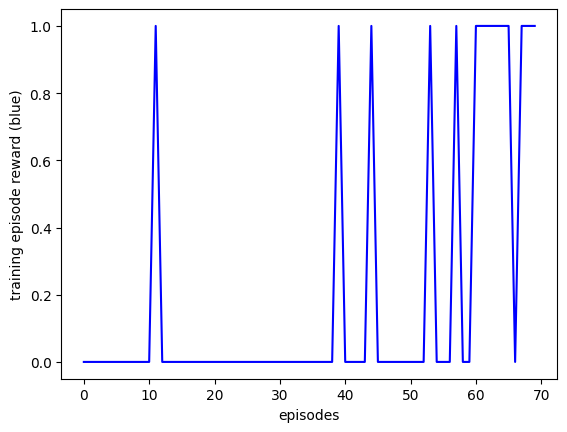

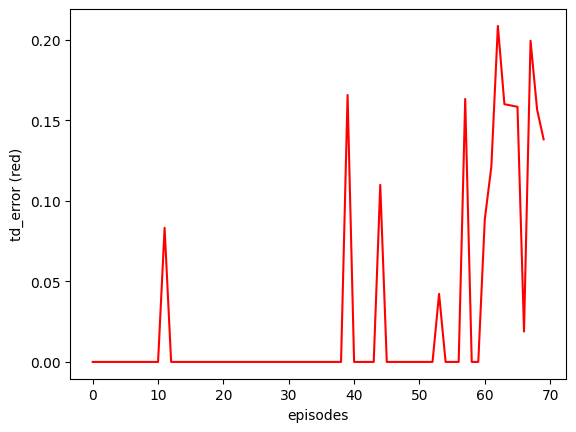

PLAY EPISODE SUCCESS!!! (TOTAL STEPS: 7)


In [26]:
if __name__ == "__main__":
    main()